# Analysis Template

## Preprocess

In [5]:
# resolve dependency
# !pip install pmdarima

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from pmdarima.arima import ADFTest , auto_arima
%matplotlib inline

In [7]:
data_path = "C:/crime_project/data/battery_occurrence_per_day/part-00000-b9840532-c606-44af-b2b6-2b9d5047f534-c000.csv"
crime = "type1"
target = "Count"
date = "Date"
city = "chicago"
fig_size = (20,5)

In [8]:
df_by_day = pd.read_csv(data_path)
df_by_day[date] = pd.to_datetime(df_by_day[date])
df_by_day.set_index(date, inplace=True)

## Profiling

### By day

In [9]:
df_by_day.head()

,Count
Date,
2001-01-01,296
2001-01-02,143
2001-01-03,165
2001-01-04,173
2001-01-05,178


In [10]:
df_by_day.describe()

,Count
count,9086.000000
mean,169.393462
std,60.251407
min,2.000000
25%,122.000000
50%,154.000000
75%,209.000000
max,423.000000


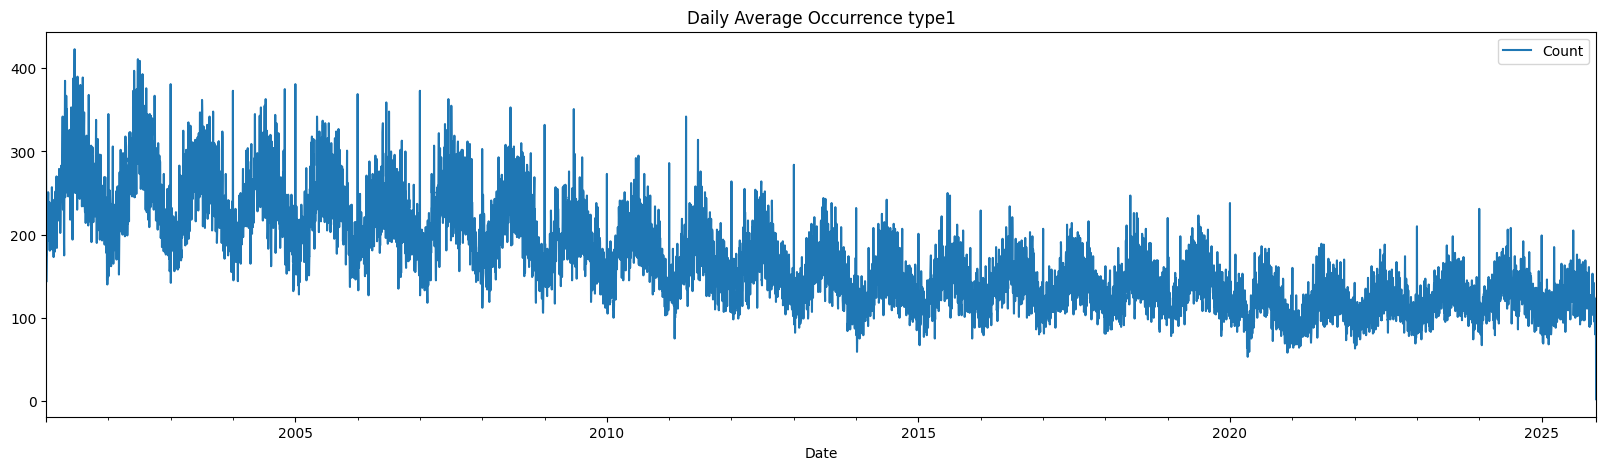

In [11]:
df_by_day.plot(figsize=fig_size, title="Daily Average Occurrence " + crime)
plt.show()

In [12]:
df_by_day[target].sort_values(ascending=False).head()

Date
2001-06-17    423
2002-06-23    411
2002-07-04    409
2002-06-01    397
2002-07-20    393
Name: Count, dtype: int64

### By week

In [13]:
df_by_week = pd.DataFrame(df_by_day[target].resample('W').mean())

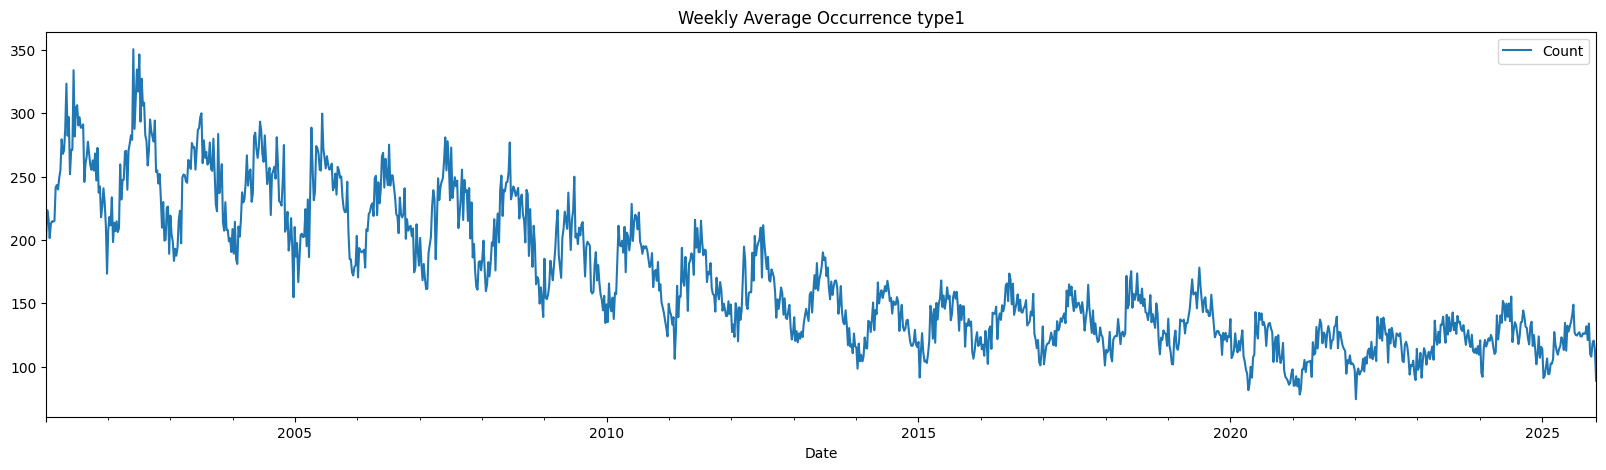

In [14]:
df_by_week.plot(
    figsize=fig_size,
    title="Weekly Average Occurrence " + crime)
plt.show()

### By month

In [15]:
df_by_month = pd.DataFrame(df_by_day[target].resample('M').mean())

C:\Users\nancy\AppData\Local\Temp\ipykernel_20864\261612041.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_by_month = pd.DataFrame(df_by_day[target].resample('M').mean())


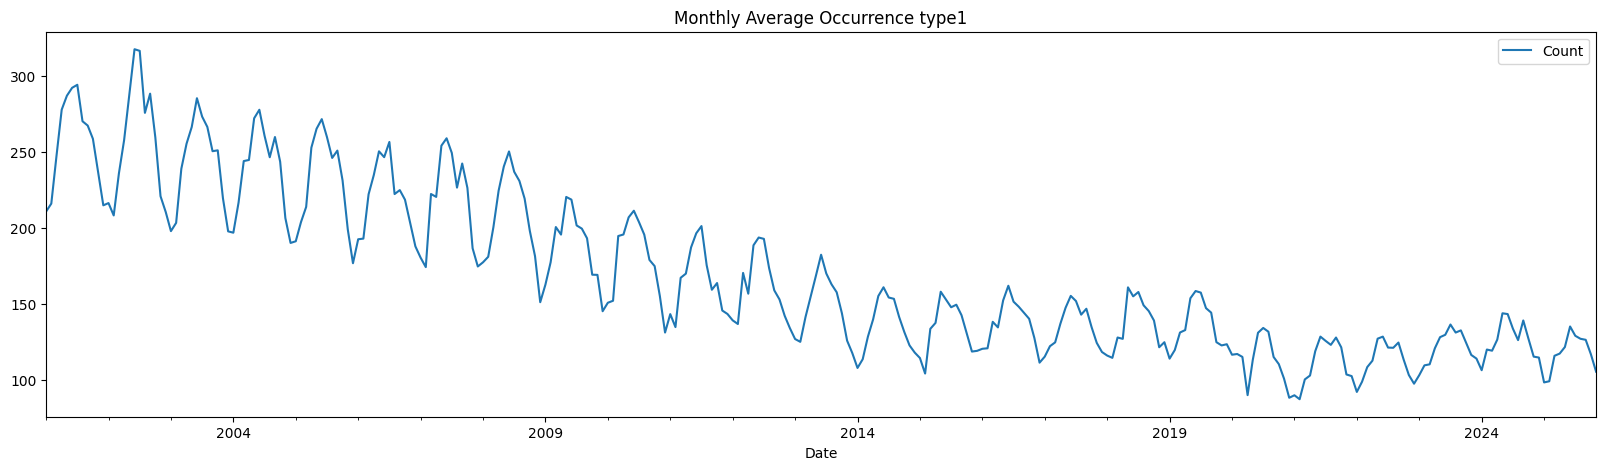

In [16]:
df_by_month.plot(
    figsize=fig_size, 
    title="Monthly Average Occurrence " + crime)
plt.show()

## Analysis

In [17]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(count):
    result=adfuller(count)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

### Checking stationary

In [18]:
adfuller_test(df_by_month[target])

ADF Test Statistic : -1.549134647377666
p-value : 0.5090804221445527
#Lags Used : 14
Number of Observations Used : 284
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


### Checking seasonality

In [19]:
df_by_month['seasonal_first_difference'] = df_by_month[target] - df_by_month[target].shift(12)

In [20]:
adfuller_test(df_by_month['seasonal_first_difference'].dropna())

ADF Test Statistic : -3.681494029193477
p-value : 0.004381116688464742
#Lags Used : 13
Number of Observations Used : 273
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


<Axes: title={'center': 'Seasonal difference plot - type1'}, xlabel='Date'>

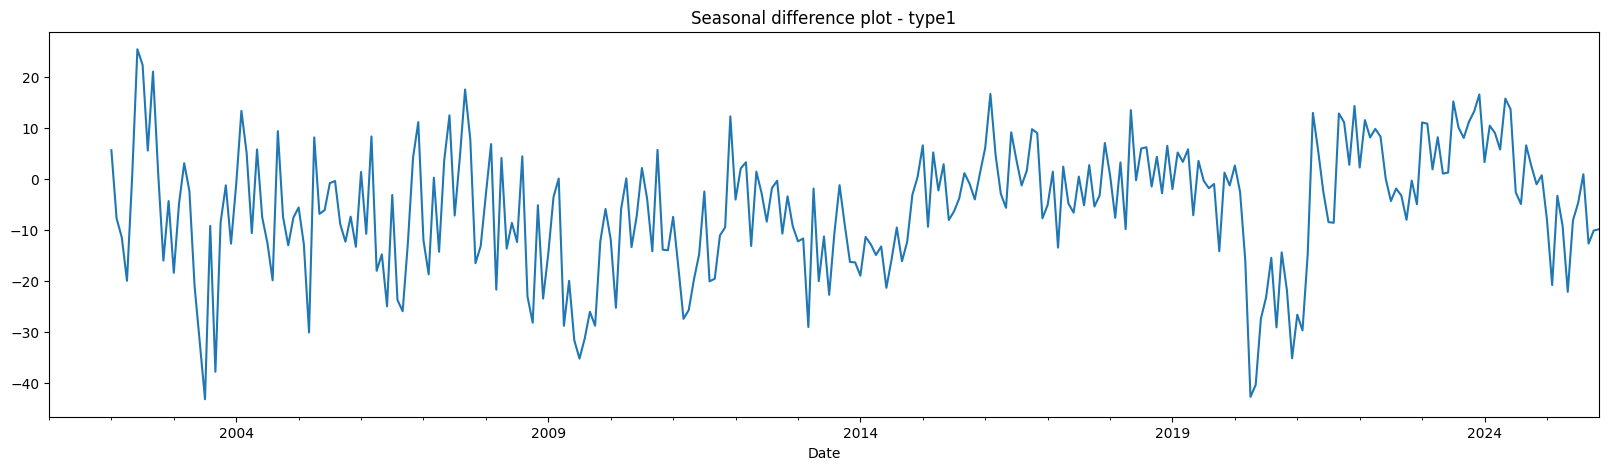

In [21]:
df_by_month['seasonal_first_difference'].plot(figsize=fig_size, title='Seasonal difference plot - ' + crime)

### Auto Regressive Model

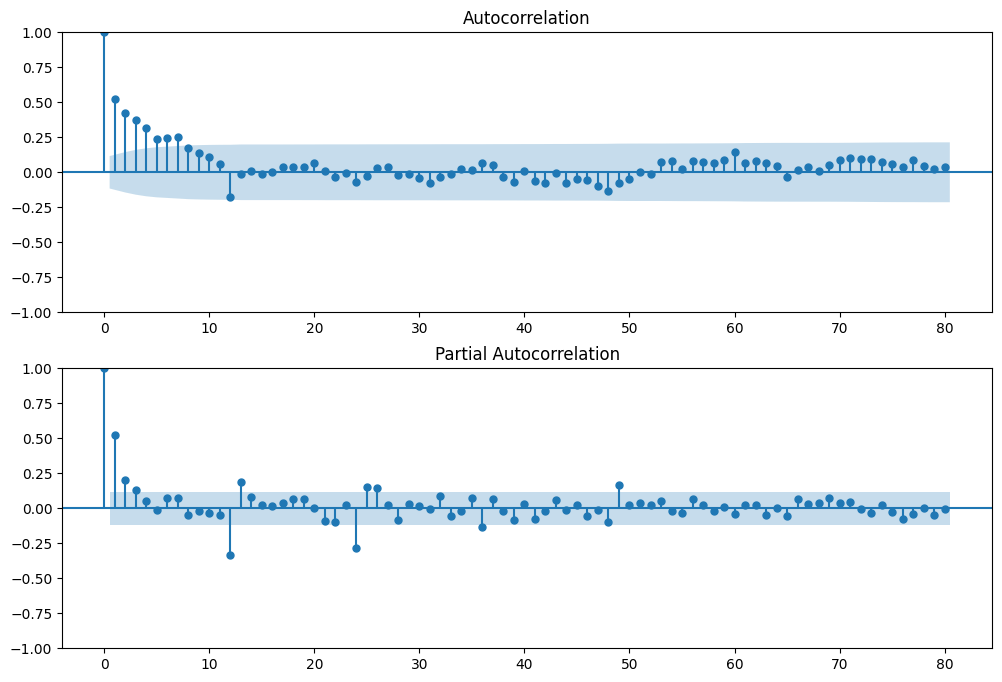

In [22]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_by_month['seasonal_first_difference'].iloc[13:],lags=80,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_by_month['seasonal_first_difference'].iloc[13:],lags=80,ax=ax2)

### Implementing Seasonal Arima Model

In [23]:
adf_test=ADFTest(alpha=0.05)
adf_test.should_diff(df_by_month[target])

(np.float64(0.01), np.False_)

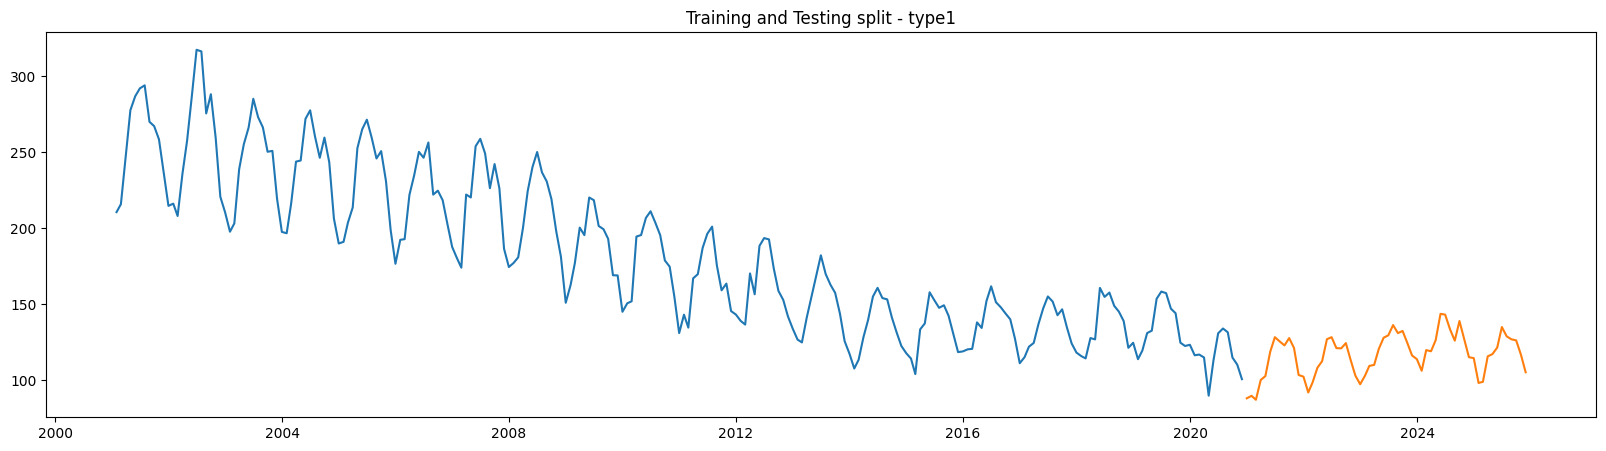

In [24]:
start=int(df_by_month.shape[0]*0.8)
train=df_by_month[:start]
test=df_by_month[start:]
plt.figure(figsize=fig_size)
plt.plot(train[target])
plt.plot(test[target])
plt.title('Training and Testing split - '+ crime)
plt.show()

In [25]:
model=auto_arima(train[target],start_p=0,d=1,start_q=0,
          max_p=10,max_d=10,max_q=10, start_P=0,
          D=1, start_Q=0, max_P=10,max_D=10,
          max_Q=10, m=12, seasonal=True,
          error_action='warn',trace=True,
          supress_warnings=True,stepwise=True,
          random_state=20,n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1789.165, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1707.403, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1657.542, Time=0.19 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1722.601, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1659.294, Time=0.26 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1659.123, Time=0.41 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1683.429, Time=0.11 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1658.219, Time=0.67 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1702.186, Time=0.10 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1650.954, Time=0.28 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1721.111, Time=0.09 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=1652.837, Time=0.41 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1652.765, Time=0.61 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=1681.292, Time=0.18 sec
 ARIMA(1,1,1)(1,1,2

In [26]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  239
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -821.477
Date:                            Fri, 05 Dec 2025   AIC                           1650.954
Time:                                    14:10:34   BIC                           1664.636
Sample:                                01-31-2001   HQIC                          1656.476
                                     - 11-30-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3292      0.092      3.582      0.000       0.149       0.509
ma.L1         -0.8397      0.059    -14.329      0.000      -0.955      -0.725
ma.S.L12      -0.6533      0.070     -9.373      0.000      -0.790      -0.517
sigma2        81.3281      7.432     10.943      0.000      66.761      95.895
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 3.43
Prob(Q):                              0.74   Prob(JB):                         0.18
Heteroskedasticity (H):               0.59   Skew:                            -0.22
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

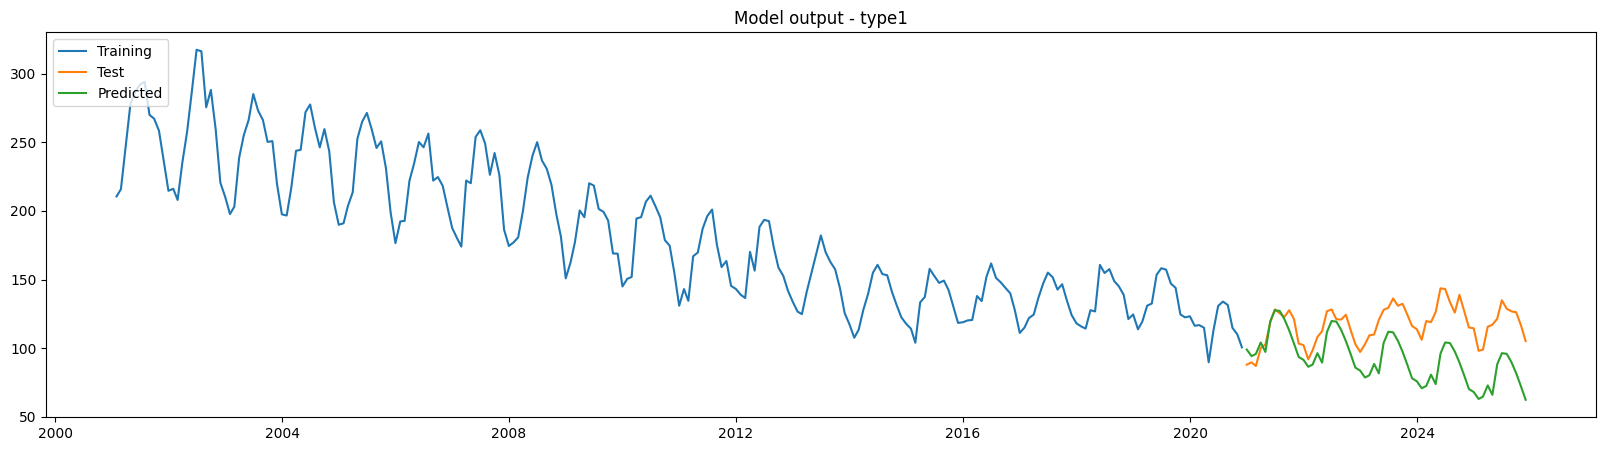

In [27]:
prediction = pd.DataFrame(model.predict(n_periods = train.shape[0]),index=test.index)
prediction.columns = ['predicted_crime']
plt.figure(figsize=fig_size)
plt.plot(train[target],label="Training")
plt.plot(test[target],label="Test")
plt.plot(prediction,label="Predicted")
plt.legend(loc = 'upper left')
plt.savefig('C:/crime_project/output/screenshot/%s_%s_pred.jpg' % (city,crime))
plt.title('Model output - '+crime)
plt.show()

In [28]:
np.sqrt(np.square(np.subtract(test[target].values,prediction['predicted_crime'].values)).mean())

np.float64(29.976802432334107)